In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
import re
%matplotlib inline

### Settings

In [2]:
# Path settings
base_path_to_csv = "/home/till/SharedFolder/trained_models/night-drive/weather_classifier/"

# Settings for epoch selection method
which_mode = "best_onemetric"  # Options: ["manual", "common", "best_onemetric", "best_eachmetric"]
# epoch to use for mode "common" epoch
epoch_common = 40  # Options: [1, 40]
# metric to use for mode "best_onemetric"
onemetric = "accuracy"  # Options: ['f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'accuracy', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc', 'train_loss', 'train_dev_loss']
# manual list of epochs for mode "manual"
list_selepochs = [[10, 10, 13, 10, 13, 10], # for each trial of run "without_cloudy"
                  [10, 10, 10, 10, 10, 10]] # for each trial of run "with_cloudy"

### Select classifier results

In [3]:
# load results and pick best epochs
# for each run and trial, these results contain a variety of metrics for all epochs for all sub-splits (train, valid, etc)
df_sel = pd.DataFrame()
df_sel_epochs = pd.DataFrame()
df_all = pd.DataFrame()
list_runs = ["without_cloudy", "with_cloudy"]
list_trials = ["train_A_over", "train_B_over", "train_C_over", "train_A_over_ganaug_025", "train_A_over_ganaug_050", "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase"]
for r, run in enumerate(list_runs):  # for each set of classifier runs
    for t, trial in enumerate(list_trials):  # for each data set
        path_to_csv = os.path.join(base_path_to_csv,run,trial)
        csv_files = glob.glob(path_to_csv + "/*.csv")
        ### Combine CSVs into one DataFrame ###
        df = pd.DataFrame()
        for csv_file in csv_files:
            df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
            df = df.reset_index(drop = True)
        ### Some preprocessing ###
        #
        df = df.drop(columns=["weights"])
        #
        df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
        df = df.sort_values(by = ["data", "epoch"])
        df = df.reset_index(drop = True)
        ### Load training log file ###
        train_log_file = glob.glob(path_to_csv + "/*.txt")
        assert(len(train_log_file) == 1)
        df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
        df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
        df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
        df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
        df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
        df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
        ### Combine loss, scores
        df_combined = df_loss.groupby(by = ["epoch"]).median()
        df_combined = df_combined.drop(columns = ["batch"])
        ### Combine loss, scores into metrics
        # df = df.join(df_combined, on="epoch")
        # stash best results according to selected method
        if which_mode in ["manual", "common"]:
            if which_mode == "manual":  # manual list of epochs, e.g. balancing overfitting and performance
                sel_epoch = list_selepochs[r][t]
            elif which_mode == "common":  # same epoch for every run
                sel_epoch = epoch_common
            rw = df.query("epoch==@sel_epoch").copy()
            rw.loc[:, "trial"] = list_trials[t]
            rw.loc[:, "run"] = list_runs[r]
            df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_onemetric":  # for each run, the best epoch accoding to one metric is selected 
            sel_epoch = []
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                rw = df_subsplit.loc[df_subsplit[onemetric].idxmax(), :].to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_eachmetric":  # all runs and metrics are evaluated independently on their best epoch 
            # find best epoch metric for each metric
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                sel_epochs = df_subsplit.loc[:,df_subsplit.columns[df_subsplit.dtypes == "float64"]].idxmax().to_frame().T
                sel_epochs.loc[:, "trial"] = list_trials[t]
                sel_epochs.loc[:, "run"] = list_runs[r]
                rw = df_subsplit.max().to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel_epochs = df_sel_epochs.append(sel_epochs, ignore_index=True, sort=True) 
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 

        # stash all data
        df_all = pd.concat([df_all, df], axis=1)

In [4]:
df.head(5)

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.416610,0.357603,0.362211,0.357603,0.507598,0.558730,0.758074,0.418042,0.556142,0.217372
1,2,test,0.617604,0.548325,0.515300,0.548325,0.635635,0.775693,0.860508,0.653937,0.708613,0.354225
2,3,test,0.773570,0.740335,0.637989,0.740335,0.716836,0.897251,0.894623,0.825988,0.769045,0.483436
3,4,test,0.813300,0.795103,0.678030,0.795103,0.735718,0.926422,0.905948,0.873937,0.792658,0.536706
4,5,test,0.811756,0.793814,0.676484,0.793814,0.736812,0.929515,0.910921,0.878833,0.803043,0.535187


In [5]:
df_sel.head(5)

,accuracy,accuracy_balanced,data,epoch,f1_score_macro,f1_score_micro,f1_score_weighted,mcc,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro,run,trial
0,0.89884,0.795133,test,30,0.802813,0.89884,0.897838,0.71684,0.855978,0.947102,0.931167,0.969566,without_cloudy,train_A_over
1,0.938538,0.919073,test_daytime,30,0.909884,0.938538,0.939112,0.87135,0.956221,0.978783,0.986369,0.988324,without_cloudy,train_A_over
2,0.873684,0.650087,test_night,30,0.669793,0.873684,0.869123,0.527729,0.703408,0.918439,0.849512,0.953797,without_cloudy,train_A_over
3,0.923899,0.92391,train_dev_A_over,12,0.923793,0.923899,0.923793,0.886022,0.972457,0.973417,0.98534,0.984951,without_cloudy,train_A_over
4,0.893041,0.791024,valid,30,0.789244,0.893041,0.893142,0.706142,0.858185,0.952391,0.939838,0.972414,without_cloudy,train_A_over


In [6]:
# print best epochs for each metric, if available
if which_mode == "best_eachmetric":
    print(df_sel_epochs.head(12))

### Print results for best epochs gouped by split

In [7]:
# Selection (and order) of columns to be printed
meta2print = ["epoch", "trial", "run"]
metrics2print = ['accuracy', 'accuracy_balanced', 'f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc']
cols2print = [*meta2print, *metrics2print]
# rename train dev sets
df_sel.data = df_sel.data.apply(lambda x: re.sub(r"_[A-C]_[a-zA-Z0-9_]*", r"", x))

#### Valid-All

In [8]:
split = "valid"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "=== Results for best manual epoch ===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid === Results for best manual epoch ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,30,train_A_over,without_cloudy,0.893041,0.791024,0.893142,0.893041,0.789244,0.972414,0.939838,0.952391,0.858185,0.706142
1,39,train_B_over,without_cloudy,0.897552,0.812419,0.898291,0.897552,0.80638,0.97604,0.954027,0.958424,0.880939,0.721004
2,32,train_C_over,without_cloudy,0.88982,0.819405,0.8931,0.88982,0.795119,0.972545,0.954703,0.950857,0.873646,0.712739
3,27,train_A_over_ganaug_025,without_cloudy,0.88982,0.790647,0.890425,0.88982,0.78597,0.971908,0.944337,0.950622,0.861707,0.699153
4,27,train_A_over_ganaug_050,without_cloudy,0.884021,0.80723,0.886765,0.884021,0.786242,0.967604,0.942439,0.944032,0.856481,0.694922
5,23,train_B_over_ganaug_025,without_cloudy,0.91366,0.827906,0.913302,0.91366,0.831803,0.977541,0.953268,0.960559,0.882669,0.760236
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.898196,0.770519,0.8957,0.898196,0.790524,0.974108,0.940357,0.955286,0.850054,0.708656
7,36,train_A_over,with_cloudy,0.832,NaN,0.830636,0.832,0.751538,0.953876,0.927669,0.886898,0.805484,0.698413
8,35,train_B_over,with_cloudy,0.8395,NaN,0.839658,0.8395,0.775809,0.959489,0.940013,0.900689,0.840947,0.716532
9,35,train_C_over,with_cloudy,0.8285,NaN,0.829755,0.8285,0.76104,0.956511,0.939627,0.894224,0.834233,0.699818


#### Valid-Night

In [9]:
split = "valid_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid_night ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,30,train_A_over,without_cloudy,0.875789,0.674616,0.874425,0.875789,0.681851,0.95854,0.873064,0.928701,0.72011,0.552767
1,39,train_B_over,without_cloudy,0.887368,0.738505,0.888559,0.887368,0.735891,0.966657,0.911709,0.942573,0.79225,0.606989
2,35,train_C_over,without_cloudy,0.876842,0.77774,0.883492,0.876842,0.731714,0.96158,0.919449,0.930945,0.80382,0.614871
3,27,train_A_over_ganaug_025,without_cloudy,0.874737,0.67845,0.873889,0.874737,0.684035,0.959963,0.887934,0.928244,0.736821,0.551563
4,27,train_A_over_ganaug_050,without_cloudy,0.865263,0.71816,0.870254,0.865263,0.696564,0.953647,0.887129,0.919382,0.743495,0.555839
5,16,train_B_over_ganaug_025,without_cloudy,0.909474,0.731702,0.905769,0.909474,0.764906,0.97212,0.913236,0.951131,0.808342,0.658809
6,23,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.886316,0.667294,0.881217,0.886316,0.697862,0.961297,0.870882,0.931004,0.710117,0.567988
7,26,train_A_over,with_cloudy,0.842,NaN,0.83676,0.842,0.625347,0.946179,0.844902,0.872777,0.641828,0.520873
8,34,train_B_over,with_cloudy,0.866,NaN,0.863483,0.866,0.69818,0.960607,0.889369,0.909754,0.73939,0.607587
9,39,train_C_over,with_cloudy,0.849,NaN,0.851635,0.849,0.687554,0.957516,0.89354,0.899728,0.737191,0.581551


In [10]:
print("\n===", split, "Difference to A ===")
one_half = df_cursplit.shape[0]//2
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:one_half-1,col] = df_cursplit_diff.loc[0:one_half-1,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[one_half:one_half*2-1,col] = df_cursplit_diff.loc[one_half:one_half*2-1,col] - df_cursplit.loc[one_half,col]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== valid_night Difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,0,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,9,train_B_over,without_cloudy,0.0115789,0.0638887,0.0141344,0.0115789,0.0540394,0.00811662,0.0386451,0.0138724,0.0721398,0.0542217
2,5,train_C_over,without_cloudy,0.00105263,0.103124,0.0090672,0.00105263,0.0498624,0.00303961,0.0463849,0.0022448,0.0837098,0.0621043
3,-3,train_A_over_ganaug_025,without_cloudy,-0.00105263,0.0038343,-0.000535999,-0.00105263,0.00218416,0.00142216,0.01487,-0.000456094,0.0167114,-0.0012044
4,-3,train_A_over_ganaug_050,without_cloudy,-0.0105263,0.0435443,-0.00417089,-0.0105263,0.0147132,-0.00489391,0.0140648,-0.00931874,0.0233854,0.0030721
5,-14,train_B_over_ganaug_025,without_cloudy,0.0336842,0.0570855,0.0313441,0.0336842,0.0830551,0.0135792,0.0401722,0.0224303,0.0882324,0.106042
6,-7,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.0105263,-0.00732212,0.00679267,0.0105263,0.0160111,0.00275623,-0.00218256,0.00230298,-0.00999334,0.0152204
7,0,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,8,train_B_over,with_cloudy,0.024,NaN,0.0267229,0.024,0.0728331,0.014428,0.044467,0.0369777,0.0975623,0.0867138
9,13,train_C_over,with_cloudy,0.007,NaN,0.0148746,0.007,0.0622066,0.0113373,0.0486378,0.0269516,0.0953633,0.0606782


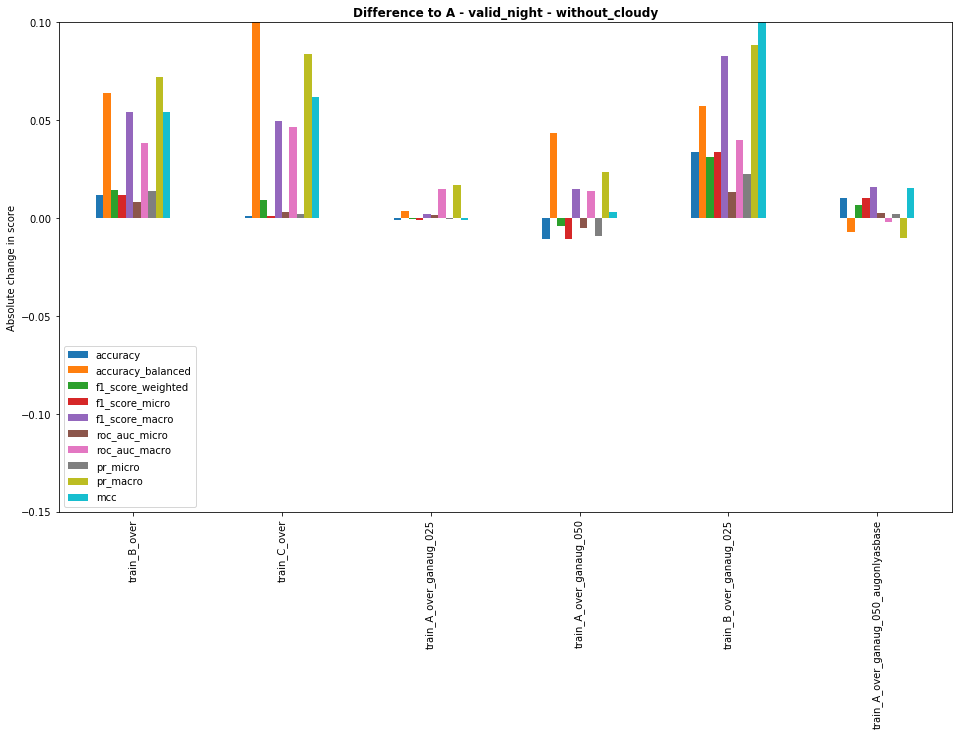

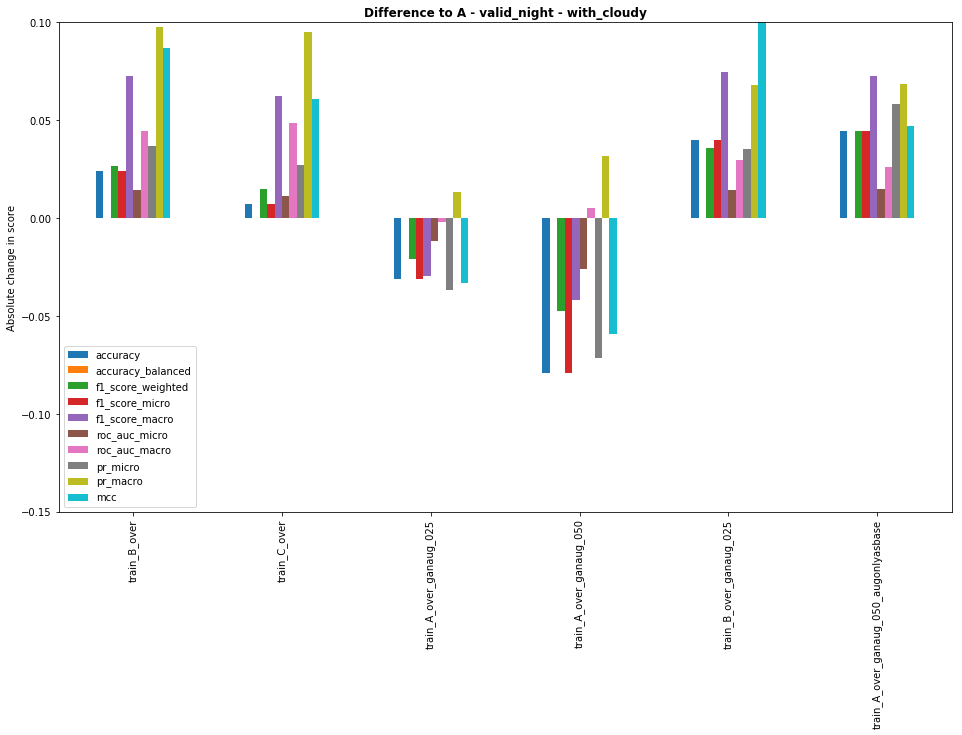

In [11]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")

#### Test-All

In [12]:
split = "test"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,30,train_A_over,without_cloudy,0.89884,0.795133,0.897838,0.89884,0.802813,0.969566,0.931167,0.947102,0.855978,0.71684
1,33,train_B_over,without_cloudy,0.902706,0.832954,0.903748,0.902706,0.821133,0.973552,0.944287,0.952568,0.882451,0.738103
2,34,train_C_over,without_cloudy,0.896263,0.831712,0.898562,0.896263,0.808772,0.970276,0.946071,0.945845,0.876829,0.727991
3,27,train_A_over_ganaug_025,without_cloudy,0.885309,0.784168,0.88575,0.885309,0.779517,0.968476,0.934657,0.945518,0.850393,0.686836
4,39,train_A_over_ganaug_050,without_cloudy,0.87951,0.793111,0.882423,0.87951,0.772439,0.965058,0.931157,0.938916,0.845764,0.683235
5,19,train_B_over_ganaug_025,without_cloudy,0.913015,0.818289,0.912103,0.913015,0.82681,0.973599,0.943301,0.954303,0.874226,0.756673
6,23,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.89433,0.785715,0.893308,0.89433,0.795694,0.969967,0.932078,0.947709,0.852153,0.703022
7,35,train_A_over,with_cloudy,0.8485,NaN,0.848104,0.8485,0.776043,0.958287,0.930479,0.898752,0.831869,0.730185
8,35,train_B_over,with_cloudy,0.8555,NaN,0.855876,0.8555,0.793282,0.962279,0.94287,0.902924,0.847821,0.745822
9,35,train_C_over,with_cloudy,0.85,NaN,0.850954,0.85,0.782636,0.961269,0.944,0.90301,0.850694,0.736677


#### Test-Night

In [13]:
split = "test_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test_night ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,30,train_A_over,without_cloudy,0.873684,0.650087,0.869123,0.873684,0.669793,0.953797,0.849512,0.918439,0.703408,0.527729
1,33,train_B_over,without_cloudy,0.888421,0.754395,0.889937,0.888421,0.740417,0.961358,0.889993,0.926588,0.789365,0.61835
2,34,train_C_over,without_cloudy,0.877895,0.750213,0.882013,0.877895,0.71954,0.956025,0.891805,0.916254,0.782574,0.600745
3,27,train_A_over_ganaug_025,without_cloudy,0.858947,0.652167,0.859315,0.858947,0.650057,0.953377,0.865235,0.917585,0.70578,0.504735
4,39,train_A_over_ganaug_050,without_cloudy,0.853684,0.681818,0.859001,0.853684,0.658343,0.947935,0.86347,0.90589,0.711012,0.519347
5,37,train_B_over_ganaug_025,without_cloudy,0.906316,0.706526,0.901057,0.906316,0.74468,0.965219,0.886844,0.937169,0.777185,0.641902
6,38,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.874737,0.638602,0.868706,0.874737,0.657994,0.953404,0.851852,0.915497,0.678939,0.52823
7,35,train_A_over,with_cloudy,0.859,NaN,0.852067,0.859,0.657703,0.950415,0.846709,0.885453,0.682197,0.565803
8,16,train_B_over,with_cloudy,0.867,NaN,0.866862,0.867,0.701427,0.957618,0.890373,0.892606,0.742923,0.623218
9,40,train_C_over,with_cloudy,0.858,NaN,0.853619,0.858,0.659759,0.957056,0.886673,0.894478,0.743259,0.58184


In [14]:
print("\n===", split, "Difference to A ===")
one_half = df_cursplit.shape[0]//2
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:one_half-1,col] = df_cursplit_diff.loc[0:one_half-1,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[one_half:one_half*2-1,col] = df_cursplit_diff.loc[one_half:one_half*2-1,col] - df_cursplit.loc[one_half,col]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== test_night Difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,0,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,3,train_B_over,without_cloudy,0.0147368,0.104308,0.0208137,0.0147368,0.0706247,0.0075615,0.0404812,0.00814907,0.0859569,0.090621
2,4,train_C_over,without_cloudy,0.00421053,0.100126,0.0128893,0.00421053,0.0497474,0.00222853,0.0422925,-0.00218496,0.0791657,0.0730151
3,-3,train_A_over_ganaug_025,without_cloudy,-0.0147368,0.00208017,-0.00980871,-0.0147368,-0.0197356,-0.000419668,0.015723,-0.000853405,0.00237148,-0.0229943
4,9,train_A_over_ganaug_050,without_cloudy,-0.02,0.0317308,-0.010122,-0.02,-0.0114499,-0.00586233,0.0139577,-0.0125489,0.00760398,-0.00838212
5,7,train_B_over_ganaug_025,without_cloudy,0.0326316,0.0564394,0.0319336,0.0326316,0.0748873,0.0114219,0.0373317,0.0187296,0.0737767,0.114173
6,8,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.00105263,-0.011485,-0.000416955,0.00105263,-0.0117985,-0.000392798,0.00233942,-0.0029422,-0.0244687,0.000500963
7,0,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,-19,train_B_over,with_cloudy,0.008,NaN,0.014795,0.008,0.0437235,0.00720333,0.0436637,0.00715261,0.0607258,0.0574151
9,5,train_C_over,with_cloudy,-0.001,NaN,0.00155211,-0.001,0.0020559,0.00664083,0.0399636,0.00902487,0.0610619,0.0160376


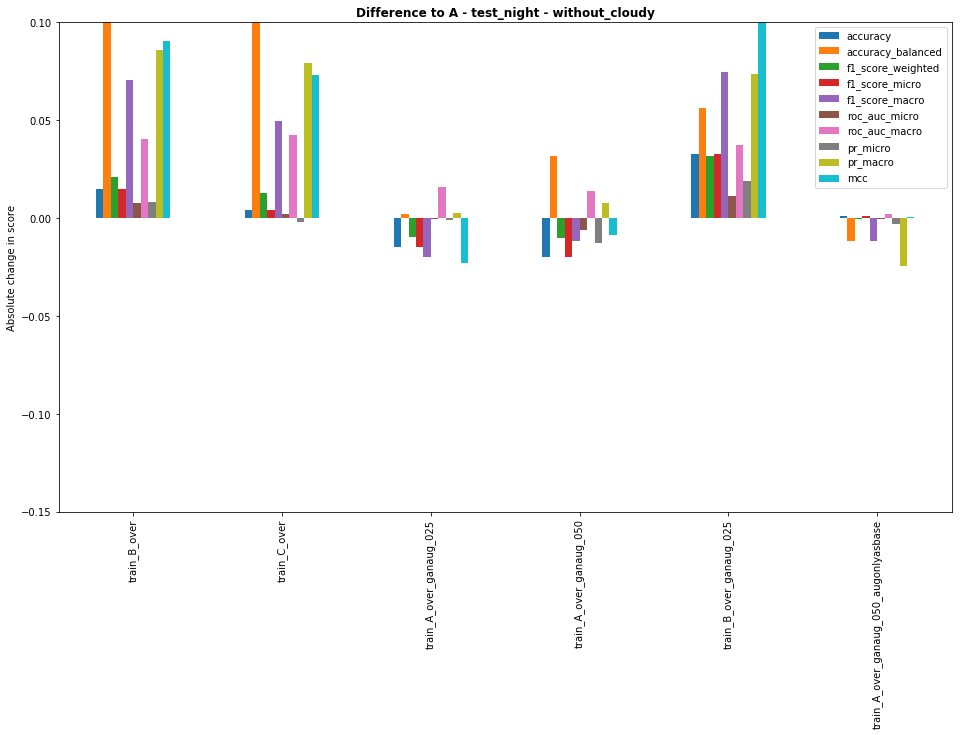

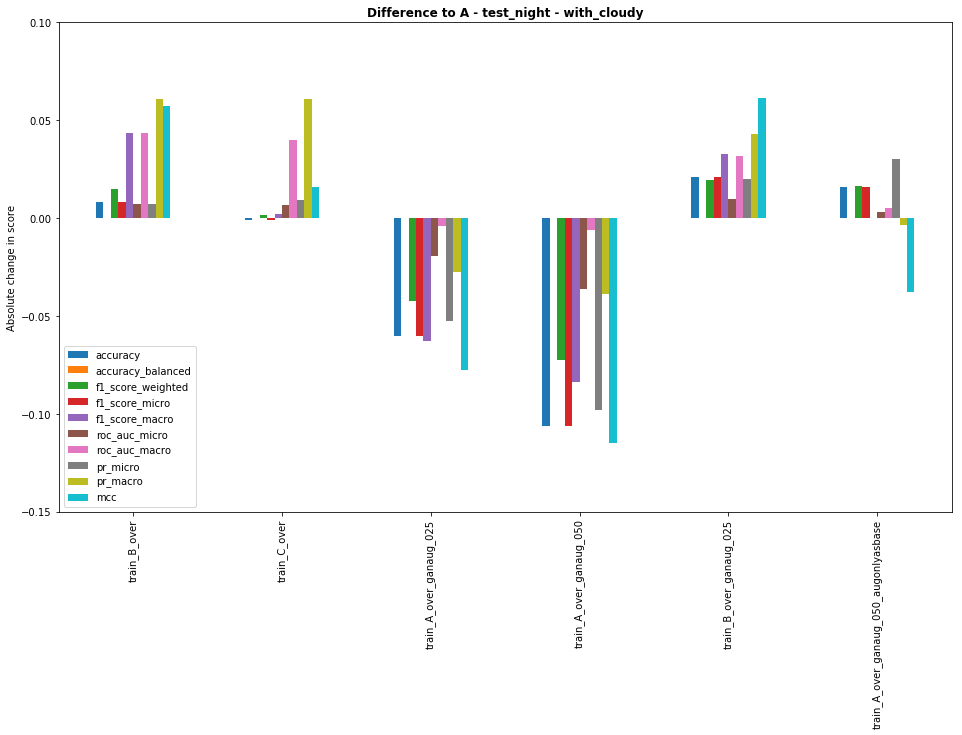

In [15]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")